# Stochastic Simulation Assignment 2
- Dennis Curti (14526263)
- Sjoerd Dronkers (13420607)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import simpy as sim
import scipy.stats as sp

## General Functions

In [3]:
def confidence_interval(mean, sem):
    """
    Compute the 95% confidence interval.
    """
    z = 1.96
    return [mean - z * sem, mean + z * sem]

In [4]:
def customer(env, servers, name, service_rate):
    """
    Function to act as a customer.
    """

    arrival = env.now

    with servers.server.request() as request:
        yield request

        # Process the customer through the server.
        yield env.process(servers.processing(service_rate))
        leave_time = env.now

        # Store waiting time spent in the queue.
        servers.waiting_times.append(leave_time - arrival - servers.service_times[-1])

In [5]:
def setup(env, servers, n, no_customers, service_time, arrival_rate):
    """
    Main function to run the system.
    """

    # Go through the number of customers to be served.
    for i in range(no_customers):
        env.process(customer(env, servers, f'Person {i}', service_time))
        yield env.timeout(np.random.exponential(arrival_rate))

## Question 2

In [6]:
class Servers(object):
    """
    Class to simulate behaviour of the servers. It processes the customers for
    the pre determined service time and tracks this time.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        self.waiting_times keeps track of the time spend in the queue.
        self.service_times tracks the time spend in the serves.
        """

        self.env = env
        self.server = sim.Resource(env, n)
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_rate):
        """
        Process a customer for the determined service_time and store this time
        spent in self.service_times.
        """

        self.service_times.append(np.random.exponential(service_rate))
        yield self.env.timeout(self.service_times[-1])


In [7]:
def simulation(n, no_customers, service_time, arrival_rate, run_time) -> list:
    env = sim.Environment()
    servers = Servers(env, n, service_time)
    env.process(setup(env, servers, n, no_customers, service_time, arrival_rate))
    env.run(until=run_time)
    return servers.waiting_times, servers.service_times

In [117]:
# Check if it works for simple cases (Calculated by hand).
# Does not work anymore after switching from deterministic to memoryless
# assert simulation(1, 2, 10, 5, 1000)[0][1] == 5
# assert simulation(2, 2, 10, 5, 1000)[0][1] == 0
# assert simulation(2, 3, 10, 3, 1000)[0][2] == 4

#### Run for rho=0.9

In [8]:
# Base parameters for rho=0.9
no_customers = 1000
service_rate = 0.9
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 1000
n = [1, 2, 4]

In [9]:
means_waiting = list()
stdev_waiting = list()

# Go through different number of servers.
for i in n:
    waiting = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))

    # Store the results for each n.
    means_waiting.append(np.mean(waiting))
    stdev_waiting.append(sp.sem(waiting))

    print(f'Simulations for {i} servers done.')

Simulations for 1 servers done.
Simulations for 2 servers done.
Simulations for 4 servers done.


In [11]:
means_waiting

[7.353925370901778, 0.37426647273164165, 0.22514280567013675]

In [12]:
stdev_waiting

[0.1314355569160485, 0.0016552541621006962, 0.0007752706990700006]

In [19]:
# Compute the 95% confidence intervals
intervals = list()
for i in range(len(means_waiting)):
    intervals.append(confidence_interval(means_waiting[i], stdev_waiting[i]))

In [20]:
intervals

[[7.096311679346323, 7.611539062457233],
 [0.3710221745739243, 0.377510770889359],
 [0.22362327509995955, 0.22666233624031396]]

#### Run for rho=0.99

In [13]:
# Base parameters for rho=0.99
no_customers = 1000
service_rate = 0.99
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 1000
n = [1, 2, 4]

In [14]:
means_waiting_rho = list()
stdev_waiting_rho = list()

# Go through different number of servers.
for i in n:
    waiting = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))

    # Store the results for each n.
    means_waiting_rho.append(np.mean(waiting))
    stdev_waiting_rho.append(sp.sem(waiting))

    print(f'Simulations for {i} servers done.')

Simulations for 1 servers done.
Simulations for 2 servers done.
Simulations for 4 servers done.


Text(0.5, 1.0, 'Average waiting time for different number of servers')

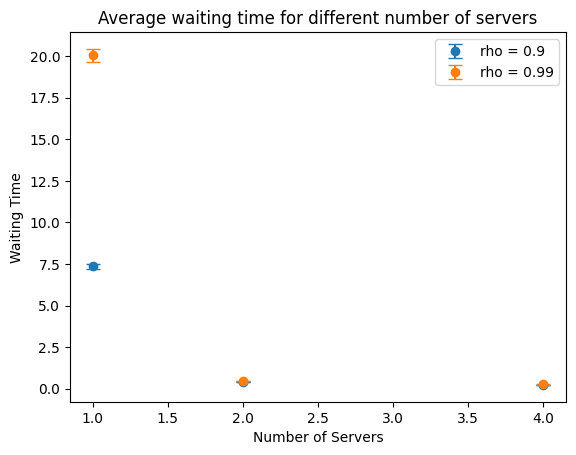

In [16]:
plt.errorbar(n, means_waiting, yerr=stdev_waiting, fmt='o', capsize=5, label='rho = 0.9')
plt.errorbar(n, means_waiting_rho, yerr=stdev_waiting_rho, fmt='o', capsize=5, label='rho = 0.99')
plt.legend()
plt.xlabel('Number of Servers')
plt.ylabel('Waiting Time')
plt.title('Average waiting time for different number of servers')

In [17]:
means_waiting_rho

[20.053603371250713, 0.4703257897217494, 0.2498344545244384]

In [18]:
stdev_waiting_rho

[0.38442029207616657, 0.0021109772526680336, 0.0008903453478518832]

In [21]:
# Compute the 95% confidence intervals
intervals = list()
for i in range(len(means_waiting)):
    intervals.append(confidence_interval(means_waiting_rho[i], stdev_waiting_rho[i]))
print(intervals)

[[19.300139598781428, 20.807067143719998], [0.46618827430652005, 0.4744633051369787], [0.2480893776426487, 0.2515795314062281]]


## Question 3

In [22]:
class Priority_Servers(object):
    """
    Class to simulate behaviour of the servers that prioritze lower values.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        """

        self.env = env
        self.server = sim.PriorityResource(env, n)
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_time):
        self.service_times.append(np.random.exponential(service_rate))
        yield self.env.timeout(self.service_times[-1])

In [23]:
def simulation_priority(n, no_customers, service_time, arrival_rate, run_time) -> list:
    env = sim.Environment()
    servers = Priority_Servers(env, n, service_time)
    env.process(setup(env, servers, n, no_customers, service_time, arrival_rate))
    env.run(until=run_time)
    return servers.waiting_times, servers.service_times

#### Run priority queue for rho 0.9

In [24]:
# Base parameters for rho=0.9
no_customers = 1000
service_rate = 0.90
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 1000
n = [1, 2, 4]

In [25]:
means_waiting = list()
stdev_waiting = list()

# Go through different number of servers.
for i in n:
    waiting = list()
    service = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation_priority(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))

    # Store the results for each n.
    means_waiting.append(np.mean(waiting))
    stdev_waiting.append(sp.sem(waiting))

    print(f'Simulations for {i} servers done.')

Simulations for 1 servers done.
Simulations for 2 servers done.
Simulations for 4 servers done.


In [26]:
means_waiting

[7.342210091483734, 0.37666170877021965, 0.2254833710566472]

In [27]:
stdev_waiting

[0.12186408258270526, 0.0015978754837997265, 0.0007635675277581048]

In [33]:
# Compute the 95% confidence intervals
intervals = list()
for i in range(len(means_waiting)):
    intervals.append(confidence_interval(means_waiting[i], stdev_waiting[i]))
print(intervals)

[[7.103356489621632, 7.581063693345836], [0.3735298728219722, 0.3797935447184671], [0.22398677870224132, 0.2269799634110531]]


#### Run priority queue for rho 0.99

In [36]:
# Base parameters for rho=0.99
no_customers = 1000
service_rate = 0.99
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 1000
n = [1, 2, 4]

In [37]:
means_waiting_rho = list()
stdev_waiting_rho = list()

# Go through different number of servers.
for i in n:
    waiting = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation_priority(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))

    # Store the results for each n.
    means_waiting_rho.append(np.mean(waiting))
    stdev_waiting_rho.append(sp.sem(waiting))

    print(f'Simulations for {i} servers done.')

Simulations for 1 servers done.
Simulations for 2 servers done.
Simulations for 4 servers done.


Text(0.5, 1.0, 'Average waiting time for different number of servers')

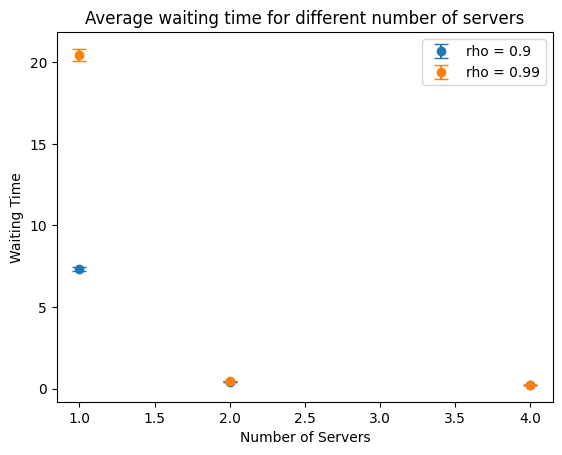

In [38]:
plt.errorbar(n, means_waiting, yerr=stdev_waiting, fmt='o', capsize=5, label='rho = 0.9')
plt.errorbar(n, means_waiting_rho, yerr=stdev_waiting_rho, fmt='o', capsize=5, label='rho = 0.99')
plt.legend()
plt.xlabel('Number of Servers')
plt.ylabel('Waiting Time')
plt.title('Average waiting time for different number of servers')

In [39]:
means_waiting_rho

[20.439480012559386, 0.47392196608899234, 0.24813487855151425]

In [40]:
stdev_waiting_rho

[0.38108719297191296, 0.002179922957114493, 0.0008633745188588471]

In [34]:
# Compute the 95% confidence intervals
intervals = list()
for i in range(len(means_waiting)):
    intervals.append(confidence_interval(means_waiting_rho[i], stdev_waiting_rho[i]))
print(intervals)

[[19.50477085597101, 21.018906242830134], [0.46541221399393645, 0.4739291336571633], [0.24973319059521681, 0.2532268711812454]]


## Question 4

#### Simulations for M/D/1 and M/D/n queues, rho=0.90

In [193]:
class MD_Servers(object):
    """
    Class to simulate behaviour of the servers that prioritze lower values.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        """

        self.env = env
        self.server = sim.Resource(env, n)
        self.service_time = service_time
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_time):
        self.service_times.append(service_time)
        yield self.env.timeout(self.service_time)

In [194]:
# Base parameters for rho=0.9
no_customers = 1000
service_rate = 0.90
arrival_rate = 1
total_time = 100000

# Simulation parameters
no_simulations = 100
n = [1, 2, 4]

In [195]:
means_waiting = list()
stdev_waiting = list()

# Go through different number of servers.
for i in n:
    waiting = list()
    service = list()

    # Go through the number of simulationes needed.
    for j in range(no_simulations):
        simu = simulation_priority(i, no_customers, service_rate, arrival_rate, total_time)
        waiting.append(np.mean(simu[0]))

    # Store the results for each n.
    means_waiting.append(np.mean(waiting))
    stdev_waiting.append(sp.sem(waiting))

    print(f'Simulations for {i} servers done.')

Simulations for 1 servers done.
Simulations for 2 servers done.
Simulations for 4 servers done.


Text(0.5, 1.0, 'Average waiting time for different number of servers')

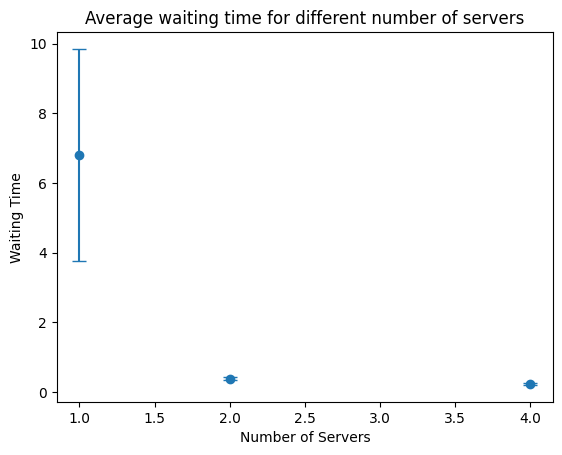

In [196]:
plt.errorbar(n, means_waiting, yerr=stdev_waiting, fmt='o', capsize=5, label='Data with Error Bars')
plt.xlabel('Number of Servers')
plt.ylabel('Waiting Time')
plt.title('Average waiting time for different number of servers')

In [197]:
means_waiting

[6.795070283590124, 0.3788124520215056, 0.22568235855603]

In [198]:
stdev_waiting

[3.050618890706604, 0.04537935978082417, 0.023936580014298846]

#### Simulations for long-tail distrbution queues

In [ ]:
class Long_Tail_Servers(object):
    """
    Class to simulate behaviour of the servers where 25% of the jobs have a longer
    service time. In other words, a long-tail distribution.
    """

    def __init__(self, env, n, service_time):
        """
        Initialize Server object.
        """

        self.env = env
        self.server = sim.Resource(env, n)
        self.waiting_times = list()
        self.service_times = list()

    def processing(self, service_time):
        """
        Change code here
        """
        self.service_times.append(service_time)
        yield self.env.timeout(self.service_time)